# VQ-VAE training example

Demonstration of how to train the model specified in https://arxiv.org/abs/1711.00937, using TF 2 / Sonnet 2.

On Mac and Linux, simply execute each cell in turn.

In [1]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np


# Uncomment the line below if running on colab.research.google.com
# !pip install dm-sonnet

try:
  # internal
  import sonnet.v2 as snt
except ImportError:
  # public
  import sonnet as snt
import tensorflow as tf

import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.1.0
Sonnet version 2.0.0


# Download Cifar10 data
This requires a connection to the internet and will download ~160MB.


In [2]:
data_path = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

local_data_dir = tempfile.mkdtemp()  # Change this as needed
os.makedirs(local_data_dir, exist_ok=True)

url = urllib.request.urlopen(data_path)
archive = tarfile.open(fileobj=url, mode='r|gz') # read a .tar.gz stream
archive.extractall(local_data_dir)
url.close()
archive.close()
print('extracted data files to %s' % local_data_dir)


extracted data files to /tmp/tmps_u83pf7


# Load the data into Numpy
We compute the variance of the whole training set to normalise the Mean Squared Error below.


In [3]:
def unpickle(filename):
  with open(filename, 'rb') as fo:
    return cPickle.load(fo, encoding='latin1')
  
def reshape_flattened_image_batch(flat_image_batch):
  return flat_image_batch.reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1])  # convert from NCHW to NHWC

def combine_batches(batch_list):
  images = np.vstack([reshape_flattened_image_batch(batch['data'])
                      for batch in batch_list])
  labels = np.vstack([np.array(batch['labels']) for batch in batch_list]).reshape(-1, 1)
  return {'images': images, 'labels': labels}
  

train_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_%d' % i))
    for i in range(1,5)
])

valid_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_5'))])

test_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir, 'cifar-10-batches-py/test_batch'))])


In [4]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [-0.5, 0.5]"""
  images = data_dict['images']
  data_dict['images'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

train_data_variance = np.var(train_data_dict['images'] / 255.0)
print('train data variance: %s' % train_data_variance)

train data variance: 0.06336906706339507


# Encoder & Decoder Architecture


In [25]:
class ResidualStack(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = snt.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = snt.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(tf.nn.relu(h))
      conv1_out = conv1(tf.nn.relu(conv3_out))
      h += conv1_out
    return tf.nn.relu(h)  # Resnet V1 style


class Encoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._enc_1 = snt.Conv2D(
        output_channels=self._num_hiddens // 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")
    self._enc_2 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")
    self._enc_3 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

  def __call__(self, x):
    h = tf.nn.relu(self._enc_1(x))
    h = tf.nn.relu(self._enc_2(h))
    h = tf.nn.relu(self._enc_3(h))
    return self._residual_stack(h)


class Decoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._dec_1 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="dec_1")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    self._dec_2 = snt.Conv2DTranspose(
        output_channels=self._num_hiddens // 2,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")
    self._dec_3 = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")
    
  def __call__(self, x):
    h = self._dec_1(x)
    h = self._residual_stack(h)
    h = tf.nn.relu(self._dec_2(h))
    x_recon = self._dec_3(h)
    return x_recon
    

class VQVAEModel(snt.Module):
  def __init__(self, encoder, decoder, vqvae, pre_vq_conv1, 
               data_variance, name=None):
    super(VQVAEModel, self).__init__(name=name)
    self._encoder = encoder
    self._decoder = decoder
    self._vqvae = vqvae
    self._pre_vq_conv1 = pre_vq_conv1
    self._data_variance = data_variance
    self._classifier = snt.Linear(10)

  def __call__(self, inputs, labels, is_training):
    z = self._pre_vq_conv1(self._encoder(inputs))
    vq_output = self._vqvae(z, is_training=is_training)
    x_recon = self._decoder(vq_output['quantize'])
    recon_error = tf.reduce_mean((x_recon - inputs) ** 2) / self._data_variance

    y_hat = self._classifier(snt.flatten(vq_output['quantize']))
    class_loss = tf.reduce_mean(tf.keras.losses.hinge(
                y_true=labels, y_pred=y_hat))
    loss = recon_error + vq_output['loss'] + class_loss
    return {
        'z': z,
        'x_recon': x_recon,
        'loss': loss,
        'recon_error': recon_error,
        'class_loss': class_loss,
        'vq_output': vq_output,
    }

# Build Model and train

In [26]:
# Set hyper-parameters.
batch_size = 32
image_size = 32

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
num_training_updates = 100000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = False

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# # Data Loading.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True))
valid_dataset = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size))

# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)
  
model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(data):
  with tf.GradientTape() as tape:
    model_output = model(data['images'], data['labels'], is_training=True)
  trainable_variables = model.trainable_variables
  grads = tape.gradient(model_output['loss'], trainable_variables)
  optimizer.apply(grads, trainable_variables)

  return model_output

train_losses = []
class_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []

for step_index, data in enumerate(train_dataset):
  train_results = train_step(data)
  train_losses.append(train_results['loss'])
  class_losses.append(train_results['class_loss'])
  train_recon_errors.append(train_results['recon_error'])
  train_perplexities.append(train_results['vq_output']['perplexity'])
  train_vqvae_loss.append(train_results['vq_output']['loss'])

  if (step_index + 1) % 100 == 0:
    print('%d. train loss: %f ' % (step_index + 1,
                                   np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f ' % np.mean(train_vqvae_loss[-100:])) +
         ('class loss: %.3f' % np.mean(class_losses[-100:])))
  if step_index == num_training_updates:
    break

100. train loss: 9.909123 recon_error: 0.766 perplexity: 2.571 vqvae loss: 9.012 class loss: 0.131
200. train loss: 52.862789 recon_error: 0.448 perplexity: 5.201 vqvae loss: 52.316 class loss: 0.098
300. train loss: 20.010546 recon_error: 0.421 perplexity: 5.998 vqvae loss: 19.490 class loss: 0.099
400. train loss: 16.859121 recon_error: 0.324 perplexity: 5.995 vqvae loss: 16.433 class loss: 0.103
500. train loss: 6.977037 recon_error: 0.278 perplexity: 7.762 vqvae loss: 6.605 class loss: 0.095
600. train loss: 6.452370 recon_error: 0.255 perplexity: 9.519 vqvae loss: 6.091 class loss: 0.107
700. train loss: 4.195155 recon_error: 0.235 perplexity: 11.375 vqvae loss: 3.856 class loss: 0.103
800. train loss: 2.960804 recon_error: 0.227 perplexity: 11.948 vqvae loss: 2.646 class loss: 0.088
900. train loss: 2.663348 recon_error: 0.225 perplexity: 11.838 vqvae loss: 2.341 class loss: 0.098
1000. train loss: 2.213988 recon_error: 0.219 perplexity: 12.344 vqvae loss: 1.885 class loss: 0.111

8300. train loss: 0.371012 recon_error: 0.095 perplexity: 45.229 vqvae loss: 0.178 class loss: 0.098
8400. train loss: 0.361349 recon_error: 0.095 perplexity: 45.020 vqvae loss: 0.177 class loss: 0.090
8500. train loss: 0.371563 recon_error: 0.094 perplexity: 45.443 vqvae loss: 0.175 class loss: 0.102
8600. train loss: 0.364499 recon_error: 0.093 perplexity: 45.613 vqvae loss: 0.176 class loss: 0.095
8700. train loss: 0.374352 recon_error: 0.095 perplexity: 45.782 vqvae loss: 0.176 class loss: 0.103
8800. train loss: 0.373875 recon_error: 0.095 perplexity: 45.990 vqvae loss: 0.177 class loss: 0.103
8900. train loss: 0.369863 recon_error: 0.095 perplexity: 46.000 vqvae loss: 0.175 class loss: 0.100
9000. train loss: 0.370575 recon_error: 0.093 perplexity: 46.485 vqvae loss: 0.174 class loss: 0.104
9100. train loss: 0.366048 recon_error: 0.093 perplexity: 47.019 vqvae loss: 0.177 class loss: 0.096
9200. train loss: 0.364984 recon_error: 0.092 perplexity: 47.256 vqvae loss: 0.177 class lo

16400. train loss: 0.400283 recon_error: 0.079 perplexity: 72.268 vqvae loss: 0.228 class loss: 0.093
16500. train loss: 0.407776 recon_error: 0.079 perplexity: 71.530 vqvae loss: 0.225 class loss: 0.104
16600. train loss: 0.403504 recon_error: 0.079 perplexity: 72.802 vqvae loss: 0.223 class loss: 0.102
16700. train loss: 0.407783 recon_error: 0.079 perplexity: 73.379 vqvae loss: 0.231 class loss: 0.098
16800. train loss: 0.400759 recon_error: 0.080 perplexity: 72.496 vqvae loss: 0.221 class loss: 0.100
16900. train loss: 0.404028 recon_error: 0.078 perplexity: 75.131 vqvae loss: 0.222 class loss: 0.104
17000. train loss: 0.398539 recon_error: 0.078 perplexity: 74.420 vqvae loss: 0.220 class loss: 0.100
17100. train loss: 0.400790 recon_error: 0.077 perplexity: 75.550 vqvae loss: 0.225 class loss: 0.098
17200. train loss: 0.406003 recon_error: 0.077 perplexity: 76.066 vqvae loss: 0.224 class loss: 0.105
17300. train loss: 0.398742 recon_error: 0.077 perplexity: 76.102 vqvae loss: 0.22

24500. train loss: 0.365368 recon_error: 0.071 perplexity: 97.126 vqvae loss: 0.205 class loss: 0.089
24600. train loss: 0.374522 recon_error: 0.070 perplexity: 96.859 vqvae loss: 0.205 class loss: 0.100
24700. train loss: 0.375722 recon_error: 0.071 perplexity: 97.638 vqvae loss: 0.206 class loss: 0.099
24800. train loss: 0.369151 recon_error: 0.070 perplexity: 98.945 vqvae loss: 0.204 class loss: 0.095
24900. train loss: 0.378964 recon_error: 0.070 perplexity: 99.588 vqvae loss: 0.206 class loss: 0.103
25000. train loss: 0.384212 recon_error: 0.071 perplexity: 100.636 vqvae loss: 0.210 class loss: 0.103
25100. train loss: 0.373471 recon_error: 0.070 perplexity: 100.368 vqvae loss: 0.205 class loss: 0.099
25200. train loss: 0.377022 recon_error: 0.070 perplexity: 100.557 vqvae loss: 0.207 class loss: 0.100
25300. train loss: 0.369344 recon_error: 0.069 perplexity: 101.041 vqvae loss: 0.202 class loss: 0.098
25400. train loss: 0.375633 recon_error: 0.070 perplexity: 102.182 vqvae loss:

32500. train loss: 0.355116 recon_error: 0.065 perplexity: 126.177 vqvae loss: 0.188 class loss: 0.101
32600. train loss: 0.354146 recon_error: 0.065 perplexity: 125.994 vqvae loss: 0.191 class loss: 0.098
32700. train loss: 0.358063 recon_error: 0.065 perplexity: 126.144 vqvae loss: 0.189 class loss: 0.104
32800. train loss: 0.360852 recon_error: 0.065 perplexity: 126.467 vqvae loss: 0.189 class loss: 0.107
32900. train loss: 0.357665 recon_error: 0.066 perplexity: 126.948 vqvae loss: 0.191 class loss: 0.102
33000. train loss: 0.362552 recon_error: 0.065 perplexity: 126.127 vqvae loss: 0.190 class loss: 0.108
33100. train loss: 0.349185 recon_error: 0.066 perplexity: 126.876 vqvae loss: 0.190 class loss: 0.094
33200. train loss: 0.353125 recon_error: 0.065 perplexity: 127.114 vqvae loss: 0.191 class loss: 0.097
33300. train loss: 0.346437 recon_error: 0.065 perplexity: 127.231 vqvae loss: 0.189 class loss: 0.093
33400. train loss: 0.348560 recon_error: 0.065 perplexity: 127.733 vqvae 

40500. train loss: 0.351453 recon_error: 0.061 perplexity: 149.908 vqvae loss: 0.184 class loss: 0.106
40600. train loss: 0.354949 recon_error: 0.061 perplexity: 150.770 vqvae loss: 0.185 class loss: 0.109
40700. train loss: 0.342000 recon_error: 0.062 perplexity: 150.990 vqvae loss: 0.187 class loss: 0.093
40800. train loss: 0.349400 recon_error: 0.063 perplexity: 151.781 vqvae loss: 0.187 class loss: 0.100
40900. train loss: 0.345235 recon_error: 0.063 perplexity: 151.452 vqvae loss: 0.187 class loss: 0.096
41000. train loss: 0.349771 recon_error: 0.062 perplexity: 151.631 vqvae loss: 0.184 class loss: 0.104
41100. train loss: 0.344490 recon_error: 0.062 perplexity: 151.981 vqvae loss: 0.185 class loss: 0.098
41200. train loss: 0.345630 recon_error: 0.061 perplexity: 151.132 vqvae loss: 0.185 class loss: 0.100
41300. train loss: 0.347565 recon_error: 0.062 perplexity: 151.782 vqvae loss: 0.185 class loss: 0.101
41400. train loss: 0.345403 recon_error: 0.061 perplexity: 152.118 vqvae 

48500. train loss: 0.336414 recon_error: 0.059 perplexity: 168.330 vqvae loss: 0.180 class loss: 0.097
48600. train loss: 0.341807 recon_error: 0.060 perplexity: 167.904 vqvae loss: 0.180 class loss: 0.102
48700. train loss: 0.340906 recon_error: 0.059 perplexity: 169.453 vqvae loss: 0.180 class loss: 0.102
48800. train loss: 0.339909 recon_error: 0.059 perplexity: 168.623 vqvae loss: 0.179 class loss: 0.101
48900. train loss: 0.333355 recon_error: 0.059 perplexity: 167.977 vqvae loss: 0.180 class loss: 0.095
49000. train loss: 0.348028 recon_error: 0.060 perplexity: 169.836 vqvae loss: 0.183 class loss: 0.105
49100. train loss: 0.336063 recon_error: 0.060 perplexity: 169.127 vqvae loss: 0.182 class loss: 0.094
49200. train loss: 0.349730 recon_error: 0.062 perplexity: 160.378 vqvae loss: 0.180 class loss: 0.107
49300. train loss: 0.347282 recon_error: 0.065 perplexity: 155.881 vqvae loss: 0.182 class loss: 0.100
49400. train loss: 0.312457 recon_error: 0.063 perplexity: 157.914 vqvae 

56500. train loss: 0.339441 recon_error: 0.058 perplexity: 182.468 vqvae loss: 0.177 class loss: 0.104
56600. train loss: 0.324747 recon_error: 0.058 perplexity: 183.443 vqvae loss: 0.175 class loss: 0.092
56700. train loss: 0.327585 recon_error: 0.058 perplexity: 182.401 vqvae loss: 0.176 class loss: 0.094
56800. train loss: 0.333593 recon_error: 0.058 perplexity: 183.187 vqvae loss: 0.176 class loss: 0.100
56900. train loss: 0.326813 recon_error: 0.058 perplexity: 183.042 vqvae loss: 0.175 class loss: 0.093
57000. train loss: 0.347255 recon_error: 0.058 perplexity: 183.131 vqvae loss: 0.178 class loss: 0.112
57100. train loss: 0.329634 recon_error: 0.059 perplexity: 184.231 vqvae loss: 0.178 class loss: 0.093
57200. train loss: 0.338204 recon_error: 0.058 perplexity: 183.140 vqvae loss: 0.176 class loss: 0.104
57300. train loss: 0.343610 recon_error: 0.059 perplexity: 184.059 vqvae loss: 0.178 class loss: 0.107
57400. train loss: 0.335128 recon_error: 0.057 perplexity: 183.823 vqvae 

64500. train loss: 0.328605 recon_error: 0.057 perplexity: 198.748 vqvae loss: 0.172 class loss: 0.100
64600. train loss: 0.327013 recon_error: 0.057 perplexity: 200.421 vqvae loss: 0.175 class loss: 0.095
64700. train loss: 0.315871 recon_error: 0.062 perplexity: 168.016 vqvae loss: 0.158 class loss: 0.096
64800. train loss: 0.328211 recon_error: 0.057 perplexity: 198.936 vqvae loss: 0.165 class loss: 0.106
64900. train loss: 0.320074 recon_error: 0.058 perplexity: 201.454 vqvae loss: 0.169 class loss: 0.093
65000. train loss: 0.335614 recon_error: 0.056 perplexity: 200.806 vqvae loss: 0.170 class loss: 0.109
65100. train loss: 0.324934 recon_error: 0.063 perplexity: 169.924 vqvae loss: 0.159 class loss: 0.103
65200. train loss: 0.315078 recon_error: 0.057 perplexity: 200.196 vqvae loss: 0.160 class loss: 0.098
65300. train loss: 0.322679 recon_error: 0.057 perplexity: 202.177 vqvae loss: 0.166 class loss: 0.099
65400. train loss: 0.328028 recon_error: 0.057 perplexity: 202.839 vqvae 

72500. train loss: 0.331104 recon_error: 0.056 perplexity: 209.973 vqvae loss: 0.171 class loss: 0.104
72600. train loss: 0.331209 recon_error: 0.056 perplexity: 210.443 vqvae loss: 0.170 class loss: 0.106
72700. train loss: 0.326038 recon_error: 0.056 perplexity: 210.711 vqvae loss: 0.170 class loss: 0.100
72800. train loss: 0.316060 recon_error: 0.056 perplexity: 212.762 vqvae loss: 0.171 class loss: 0.089
72900. train loss: 0.339379 recon_error: 0.056 perplexity: 210.682 vqvae loss: 0.172 class loss: 0.112
73000. train loss: 0.323756 recon_error: 0.056 perplexity: 211.014 vqvae loss: 0.170 class loss: 0.098
73100. train loss: 0.322832 recon_error: 0.056 perplexity: 211.680 vqvae loss: 0.170 class loss: 0.097
73200. train loss: 0.316834 recon_error: 0.056 perplexity: 211.412 vqvae loss: 0.170 class loss: 0.091
73300. train loss: 0.325171 recon_error: 0.056 perplexity: 210.595 vqvae loss: 0.170 class loss: 0.100
73400. train loss: 0.320531 recon_error: 0.056 perplexity: 211.700 vqvae 

80500. train loss: 0.317549 recon_error: 0.054 perplexity: 220.219 vqvae loss: 0.166 class loss: 0.097
80600. train loss: 0.326462 recon_error: 0.055 perplexity: 221.686 vqvae loss: 0.169 class loss: 0.102
80700. train loss: 0.323946 recon_error: 0.054 perplexity: 218.238 vqvae loss: 0.166 class loss: 0.104
80800. train loss: 0.317099 recon_error: 0.056 perplexity: 221.820 vqvae loss: 0.171 class loss: 0.091
80900. train loss: 0.327126 recon_error: 0.055 perplexity: 219.095 vqvae loss: 0.166 class loss: 0.106
81000. train loss: 0.321764 recon_error: 0.054 perplexity: 218.888 vqvae loss: 0.165 class loss: 0.102
81100. train loss: 0.324000 recon_error: 0.056 perplexity: 222.939 vqvae loss: 0.170 class loss: 0.098
81200. train loss: 0.321502 recon_error: 0.054 perplexity: 219.753 vqvae loss: 0.167 class loss: 0.101
81300. train loss: 0.321762 recon_error: 0.056 perplexity: 220.892 vqvae loss: 0.169 class loss: 0.097
81400. train loss: 0.327234 recon_error: 0.055 perplexity: 220.865 vqvae 

88500. train loss: 0.316846 recon_error: 0.054 perplexity: 226.504 vqvae loss: 0.165 class loss: 0.098
88600. train loss: 0.314645 recon_error: 0.054 perplexity: 228.294 vqvae loss: 0.166 class loss: 0.095
88700. train loss: 0.320430 recon_error: 0.055 perplexity: 228.191 vqvae loss: 0.169 class loss: 0.097
88800. train loss: 0.319661 recon_error: 0.054 perplexity: 227.853 vqvae loss: 0.167 class loss: 0.098
88900. train loss: 0.321667 recon_error: 0.055 perplexity: 228.651 vqvae loss: 0.166 class loss: 0.101
89000. train loss: 0.313600 recon_error: 0.055 perplexity: 228.906 vqvae loss: 0.167 class loss: 0.092
89100. train loss: 0.315233 recon_error: 0.054 perplexity: 228.351 vqvae loss: 0.164 class loss: 0.097
89200. train loss: 0.320508 recon_error: 0.054 perplexity: 228.768 vqvae loss: 0.167 class loss: 0.099
89300. train loss: 0.322379 recon_error: 0.054 perplexity: 228.348 vqvae loss: 0.165 class loss: 0.103
89400. train loss: 0.324874 recon_error: 0.054 perplexity: 226.993 vqvae 

96500. train loss: 0.328212 recon_error: 0.053 perplexity: 234.883 vqvae loss: 0.164 class loss: 0.111
96600. train loss: 0.317182 recon_error: 0.054 perplexity: 236.581 vqvae loss: 0.166 class loss: 0.098
96700. train loss: 0.320781 recon_error: 0.054 perplexity: 236.868 vqvae loss: 0.165 class loss: 0.102
96800. train loss: 0.312972 recon_error: 0.054 perplexity: 237.428 vqvae loss: 0.166 class loss: 0.093
96900. train loss: 0.322475 recon_error: 0.054 perplexity: 236.972 vqvae loss: 0.166 class loss: 0.103
97000. train loss: 0.320565 recon_error: 0.053 perplexity: 235.748 vqvae loss: 0.166 class loss: 0.102
97100. train loss: 0.320690 recon_error: 0.054 perplexity: 238.192 vqvae loss: 0.168 class loss: 0.099
97200. train loss: 0.318064 recon_error: 0.053 perplexity: 235.337 vqvae loss: 0.165 class loss: 0.099
97300. train loss: 0.324588 recon_error: 0.055 perplexity: 237.995 vqvae loss: 0.169 class loss: 0.100
97400. train loss: 0.314011 recon_error: 0.053 perplexity: 236.464 vqvae 

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

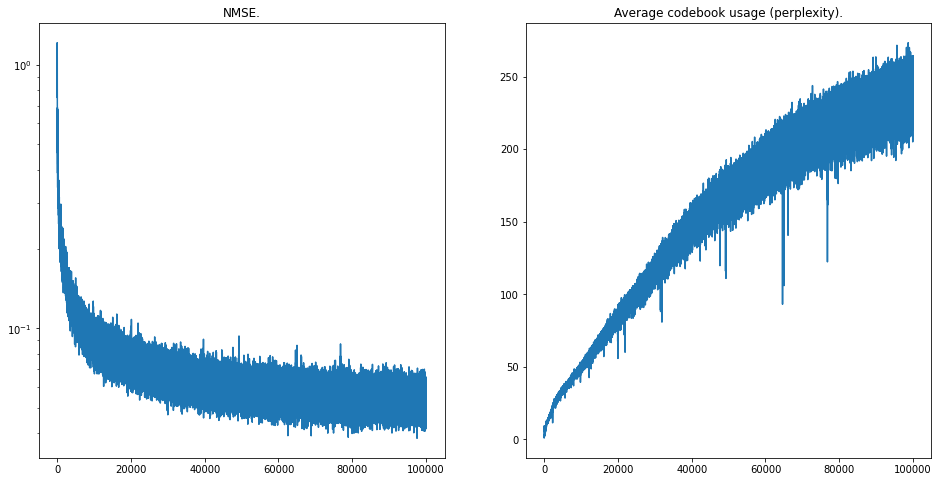

In [27]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_errors)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_perplexities)
ax.set_title('Average codebook usage (perplexity).')


# View reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 127.5, -0.5)

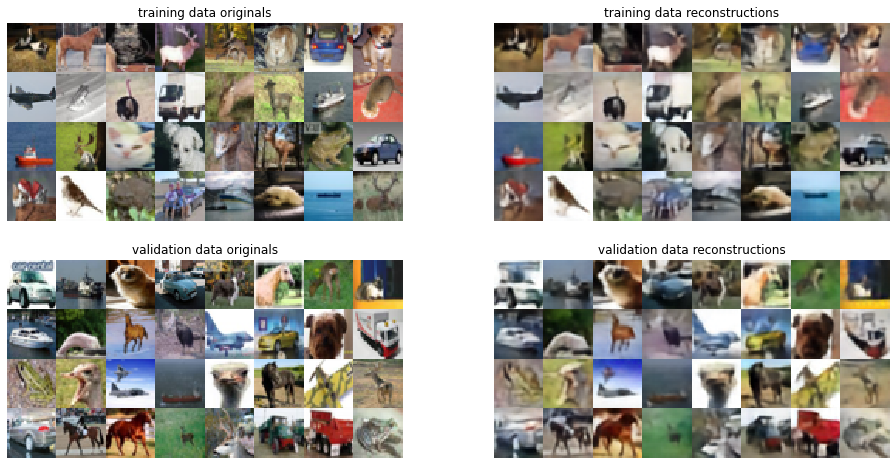

In [30]:
# Reconstructions
train_batch = next(iter(train_dataset))
valid_batch = next(iter(valid_dataset))

# Put data through the model with is_training=False, so that in the case of 
# using EMA the codebook is not updated.
train_reconstructions = model(train_batch['images'], train_batch['labels'],
                              is_training=False)['x_recon'].numpy()
valid_reconstructions = model(valid_batch['images'], train_batch['labels'],
                              is_training=False)['x_recon'].numpy()


def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 32, 8 * 32, 3))
  return reshaped + 0.5



f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_batch['images'].numpy()),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_batch['images'].numpy()),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')
